In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Unzip

In [2]:
!unzip /content/drive/MyDrive/blockchain/Brain_Tumor.zip >& /dev/null

In [3]:
!unzip /content/drive/MyDrive/blockchain/Dataset.zip >& /dev/null

# Libraries

In [4]:
!pip install tensorflow_addons

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.8/611.8 kB 11.8 MB/s eta 0:00:00


In [5]:
import random
import numpy as np
from  drive.MyDrive.blockchain.classHospital import Hospital
import os
import cv2
import pickle
import pandas as pd
import gc
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.constraints import MaxNorm
from tensorflow.keras.initializers import GlorotUniform, Zeros
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Rescaling
from sklearn.metrics import classification_report, f1_score, accuracy_score
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.metrics import f1_score
import tensorflow_addons as tfa

/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


# Constants

In [6]:
BRAIN_TUMOR = "Brain_Tumor"
ALZHEIMER = "Alzheimer"


RANDOM_SEED = 42
LABELS_ALZ = ["NonDemented", "VeryMildDemented", "MildDemented", "ModerateDemented"]
LABELS_TUMOR = ["glioma", "meningioma", "notumor", "pituitary"]
NUM_CLASSES = 4
COMPILE_INFO = {
    "optimizer": "Adam",
    "metrics": ["accuracy"],
}
WIDTH = 176
HEIGHT = 208
DEPTH = 1
BATCH_SIZE = 32
DATASET_TRAIN_PATH_ALZ = "/content/Dataset/train"
DATASET_TEST_PATH_ALZ = "/content/Dataset/test"
DATASET_TRAIN_PATH_TUM = "/content/Brain_Tumor/train"
DATASET_TEST_PATH_TUM = "/content/Brain_Tumor/test"

train_path = DATASET_TRAIN_PATH_TUM
test_path = DATASET_TEST_PATH_TUM

In [7]:
def set_riproducibility():
  os.environ["PYTHONHASHSEED"] = str(RANDOM_SEED)
  random.seed(RANDOM_SEED)
  np.random.seed(RANDOM_SEED)
  tf.random.set_seed(RANDOM_SEED)
  os.environ["TF_DETERMINISTIC_OPS"] = "1"
  os.environ["TF_CUDNN_DETERMINISTIC"] = "1"
  tf.keras.utils.set_random_seed(RANDOM_SEED)
set_riproducibility()

# Setup

In [8]:
def preprocess_data(image, label):
    label = tf.one_hot(label, depth=NUM_CLASSES)
    return image, label

def count_classes(dataset):
    class_names = LABELS_ALZ if train_path == DATASET_TRAIN_PATH_ALZ else LABELS_TUMOR
    class_counts = [0] * len(class_names)
    for _, labels in dataset:
        class_counts += np.sum(labels.numpy(), axis=0)
    return class_counts

def create_dataset(train_path, test_path, dataset_name):

    labels = LABELS_ALZ if train_path == DATASET_TRAIN_PATH_ALZ else LABELS_TUMOR

    test_dataset = tf.keras.preprocessing.image_dataset_from_directory(
      test_path,
      seed=RANDOM_SEED,
      image_size=(WIDTH,HEIGHT),
      batch_size=BATCH_SIZE,
      class_names = labels,
      color_mode='grayscale',
      shuffle = False
      )

    train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
      train_path,
      seed=RANDOM_SEED,
      image_size=(WIDTH,HEIGHT),
      batch_size= BATCH_SIZE, # it is needed for the split
      class_names = labels,
      color_mode='grayscale',
      shuffle = True
      )


    # one hot encoding

    train_dataset = train_dataset.map(preprocess_data)

    test_dataset = test_dataset.map(preprocess_data)

    return train_dataset, test_dataset

## Model

In [9]:
class FedAvg(tf.keras.Model):

    def __init__(self, num_classes=4, random_seed=42):
        super(FedAvg, self).__init__()


        # Layers
        self.glorot_initializer = GlorotUniform(seed=random_seed)
        self.rescale_layer = Rescaling(1.0 / 255)
        self.conv1 = Conv2D(
            16,
            3,
            padding="same",
            activation="relu",
            kernel_initializer=self.glorot_initializer)
        self.pool = MaxPooling2D((2, 2))
        self.conv2 = Conv2D(32, 3, padding="same", activation="relu", kernel_initializer=self.glorot_initializer)
        self.conv3 = Conv2D(
            64,
            3,
            padding="same",
            activation="relu",
            kernel_initializer=self.glorot_initializer,
        )
        self.flatten_layer = Flatten()
        self.dense1 = Dense(
            128,
            activation="relu",
            kernel_initializer=self.glorot_initializer,
            kernel_constraint=MaxNorm(3),
        )
        self.dropout_layer = Dropout(0.3, seed=random_seed)
        self.dense2 = Dense(
            num_classes,
            activation="softmax",
            kernel_initializer=self.glorot_initializer,
        )

    def call(self, inputs):

        x = self.rescale_layer(inputs)
        x = self.conv1(x)
        x = self.pool(x)
        x = self.conv2(x)
        x = self.pool(x)
        x = self.conv3(x)
        x = self.pool(x)

        x = self.flatten_layer(x)
        x = self.dense1(x)
        x = self.dropout_layer(x)
        x = self.dense2(x)

        return x

    """
    @tf.function
    def train_step(self, inputs, labels):
        with tf.GradientTape() as tape:
            predictions = self(inputs, training=True)
            loss = tf.keras.losses.categorical_crossentropy(labels, predictions)

        gradients = tape.gradient(loss, self.trainable_variables)
        self.optimizer.apply_gradients(zip(gradients, self.trainable_variables))
        return loss

    def val_step(self, x_val, y_val):
        predictions = self(x_val, training=False)  # Predict using the model

        # Calculate loss (you can use a different metric if needed)
        loss = tf.keras.losses.categorical_crossentropy(y_val, predictions)

        return loss
    """



# Brain Tumor

## Dataset Creation and exploration

In [10]:
train_dataset, test_dataset = create_dataset(train_path, test_path,BRAIN_TUMOR)

Found 1281 files belonging to 4 classes.
Found 5505 files belonging to 4 classes.


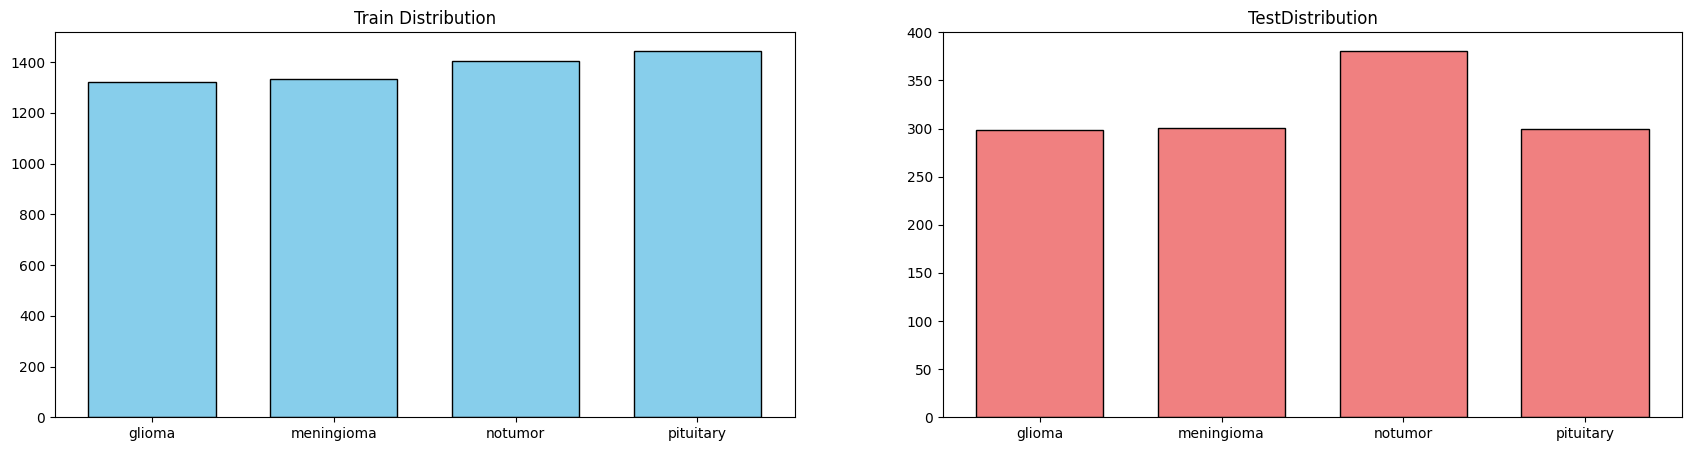

In [11]:
train_count = count_classes(train_dataset)

test_count = count_classes(test_dataset)

fig, axes = plt.subplots(1, 2, figsize=(21, 5))

class_names = LABELS_ALZ if train_path == DATASET_TRAIN_PATH_ALZ else LABELS_TUMOR

# Plot for training set
ax1 = axes[0]
ax1.bar(class_names, train_count, edgecolor="black", color="skyblue", width=0.7)
ax1.set_title("Train Distribution")

# Plot for test set
ax3 = axes[1]
ax3.bar(class_names, test_count, edgecolor="black", color="lightcoral", width=0.7)
ax3.set_title("TestDistribution")

plt.show()


## Training

In [12]:
def history_plot(history):
  plt.plot(history.history['loss'], label='Train Loss')
  plt.plot(history.history['val_loss'], label='Validation Loss')
  plt.title('Training and Validation Loss')
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.legend()
  plt.show()

In [13]:
def predictions(dataset, model):
  y_true = []
  y_pred = []

  for images, labels in dataset:
      y_true.extend(tf.argmax(labels, axis=1).numpy())
      predictions = model(images, training=False)

      y_pred.extend(tf.argmax(predictions, axis=1).numpy())
  return y_true, y_pred

In [14]:
# Define the ModelCheckpoint callback
checkpoint_filepath = '/content/drive/MyDrive/blockchain/best_model_tum_test'
model_checkpoint = ModelCheckpoint(
    checkpoint_filepath,
    save_best_only=True,
    monitor='val_f1_score',  # Monitor the validation macro-F1 score
    mode='max',
    verbose=0,
    save_weights_only=False  # Save the entire model
)

# Create and compile the model
model = FedAvg(num_classes=4)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=[tfa.metrics.F1Score(num_classes=4,average='macro')])

# Train the model
epochs = 80
history = model.fit(train_dataset, epochs=epochs, validation_data=test_dataset, callbacks=[model_checkpoint])


Epoch 1/80
173/173 [==============================] - 14s 42ms/step - loss: 0.6307 - f1_score: 0.7368 - val_loss: 0.7171 - val_f1_score: 0.6883
Epoch 2/80
173/173 [==============================] - 7s 42ms/step - loss: 0.3702 - f1_score: 0.8555 - val_loss: 0.3920 - val_f1_score: 0.8314
Epoch 3/80
173/173 [==============================] - 7s 38ms/step - loss: 0.2659 - f1_score: 0.9007 - val_loss: 0.2680 - val_f1_score: 0.8851
Epoch 4/80
173/173 [==============================] - 7s 38ms/step - loss: 0.2338 - f1_score: 0.9105 - val_loss: 0.2497 - val_f1_score: 0.8906
Epoch 5/80
173/173 [==============================] - 8s 47ms/step - loss: 0.1728 - f1_score: 0.9340 - val_loss: 0.2070 - val_f1_score: 0.9168
Epoch 6/80
173/173 [==============================] - 6s 34ms/step - loss: 0.1579 - f1_score: 0.9435 - val_loss: 0.2027 - val_f1_score: 0.9193
Epoch 7/80
173/173 [==============================] - 8s 47ms/step - loss: 0.1408 - f1_score: 0.9517 - val_loss: 0.1862 - val_f1_score: 0.928

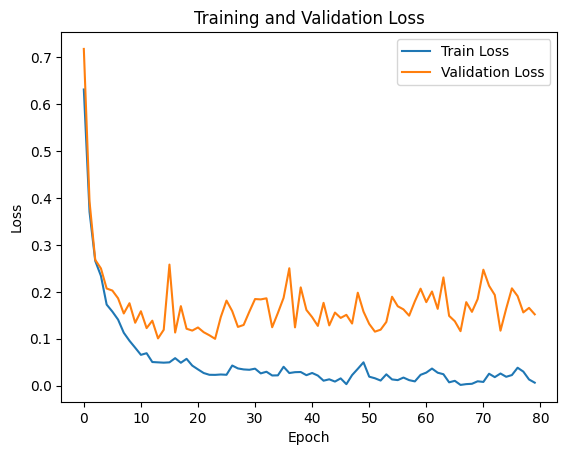

In [15]:
history_plot(history)

In [16]:
print(f"The best epoch is: {model_checkpoint.best:.3f}")

# Load the model with the best weights
best_model_path = '/content/drive/MyDrive/blockchain/best_model_tum_test'
best_model = load_model(best_model_path)

The best epoch is: 0.974


In [17]:
y_true, y_pred = predictions(test_dataset, best_model)
# Generate and print the classification report
class_names = LABELS_ALZ if train_path == DATASET_TRAIN_PATH_ALZ else LABELS_TUMOR

print("\t\tClassification report:\n")
print(classification_report(y_true, y_pred,target_names=class_names))

		Classification report:

              precision    recall  f1-score   support

      glioma       0.98      0.95      0.96       299
  meningioma       0.94      0.96      0.95       301
     notumor       0.99      1.00      0.99       381
   pituitary       0.99      0.98      0.98       300

    accuracy                           0.98      1281
   macro avg       0.97      0.97      0.97      1281
weighted avg       0.98      0.98      0.98      1281



# Alzheimer

In [18]:
train_path = DATASET_TRAIN_PATH_ALZ
test_path = DATASET_TEST_PATH_ALZ
set_riproducibility()

In [19]:
train_dataset, test_dataset = create_dataset(train_path, test_path,ALZHEIMER)

Found 1025 files belonging to 4 classes.
Found 4096 files belonging to 4 classes.


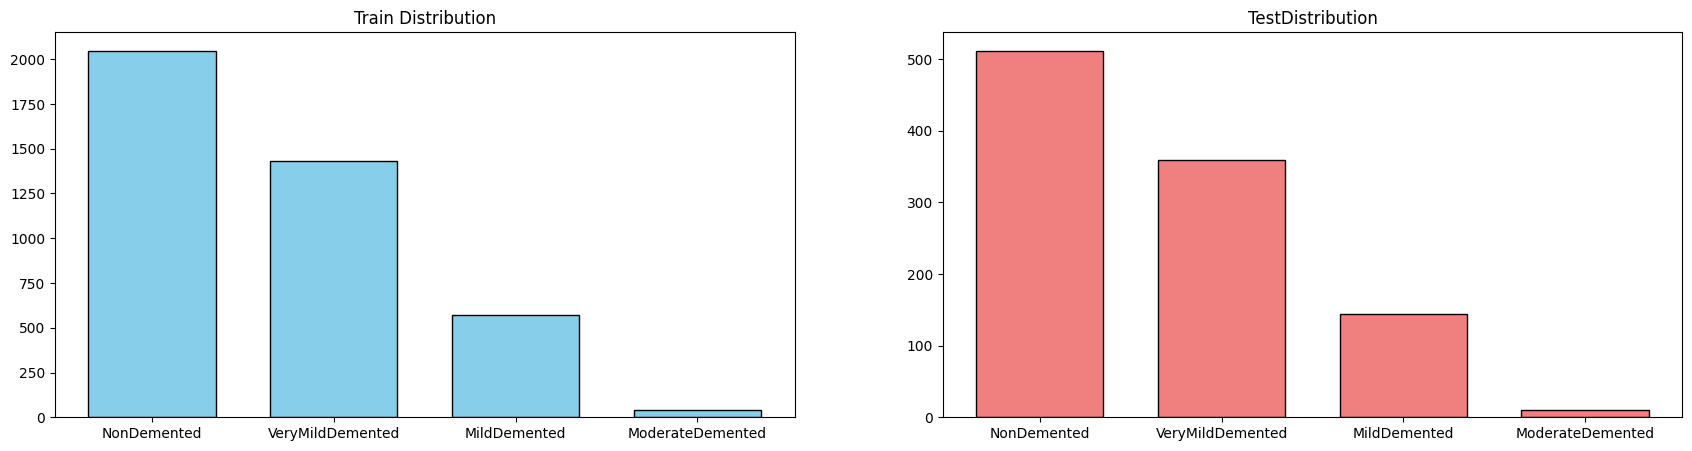

In [20]:
train_count = count_classes(train_dataset)
test_count = count_classes(test_dataset)

fig, axes = plt.subplots(1, 2, figsize=(21, 5))

class_names = LABELS_ALZ if train_path == DATASET_TRAIN_PATH_ALZ else LABELS_TUMOR

# Plot for training set
ax1 = axes[0]
ax1.bar(class_names, train_count, edgecolor="black", color="skyblue", width=0.7)
ax1.set_title("Train Distribution")

# Plot for test set
ax3 = axes[1]
ax3.bar(class_names, test_count, edgecolor="black", color="lightcoral", width=0.7)
ax3.set_title("TestDistribution")

plt.show()


## Training

In [21]:
checkpoint_filepath = '/content/drive/MyDrive/blockchain/best_model_alz_test'
model_checkpoint = ModelCheckpoint(
    checkpoint_filepath,
    save_best_only=True,
    monitor='val_f1_score',  # Monitor the validation macro-F1 score
    mode='max',
    verbose=0,
    save_weights_only=False  # Save the entire model
)

# Create and compile the model
model = FedAvg(num_classes=4)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=[tfa.metrics.F1Score(num_classes=4,average='macro')])
# Train the model
epochs = 80
history = model.fit(train_dataset, epochs=epochs, validation_data=test_dataset, callbacks=[model_checkpoint])

Epoch 1/80
128/128 [==============================] - 9s 53ms/step - loss: 1.0307 - f1_score: 0.2537 - val_loss: 0.9472 - val_f1_score: 0.3162
Epoch 2/80
128/128 [==============================] - 5s 39ms/step - loss: 0.8570 - f1_score: 0.3878 - val_loss: 0.7492 - val_f1_score: 0.4079
Epoch 3/80
128/128 [==============================] - 5s 36ms/step - loss: 0.6405 - f1_score: 0.5251 - val_loss: 0.5287 - val_f1_score: 0.5869
Epoch 4/80
128/128 [==============================] - 6s 49ms/step - loss: 0.4724 - f1_score: 0.6352 - val_loss: 0.3416 - val_f1_score: 0.7125
Epoch 5/80
128/128 [==============================] - 5s 37ms/step - loss: 0.2860 - f1_score: 0.8231 - val_loss: 0.2240 - val_f1_score: 0.9137
Epoch 6/80
128/128 [==============================] - 4s 28ms/step - loss: 0.2250 - f1_score: 0.8842 - val_loss: 0.2266 - val_f1_score: 0.8555
Epoch 7/80
128/128 [==============================] - 6s 47ms/step - loss: 0.2081 - f1_score: 0.8714 - val_loss: 0.1288 - val_f1_score: 0.9546

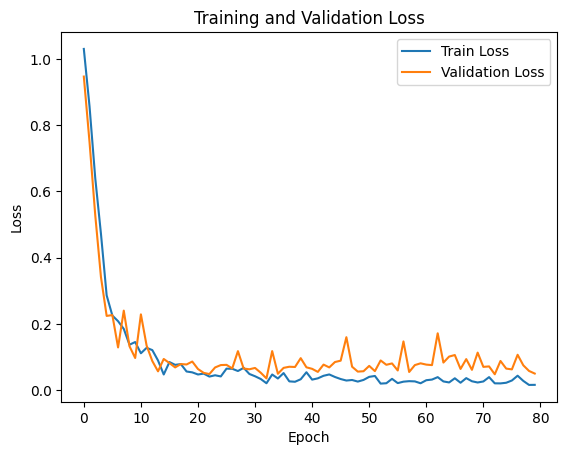

In [22]:
history_plot(history)

In [23]:
print(f"The best epoch is: {model_checkpoint.best:.3f}")

# Load the model with the best weights
best_model_path = '/content/drive/MyDrive/blockchain/best_model_alz_test'
best_model = load_model(best_model_path)

The best epoch is: 0.992


In [24]:
y_true, y_pred = predictions(test_dataset, best_model)
# Generate and print the classification report
class_names = LABELS_ALZ if train_path == DATASET_TRAIN_PATH_ALZ else LABELS_TUMOR
print("\t\tClassification report:\n")
print(classification_report(y_true, y_pred,target_names=class_names))

		Classification report:

                  precision    recall  f1-score   support

     NonDemented       0.99      0.99      0.99       512
VeryMildDemented       0.99      0.99      0.99       359
    MildDemented       0.99      0.99      0.99       144
ModerateDemented       1.00      1.00      1.00        10

        accuracy                           0.99      1025
       macro avg       0.99      0.99      0.99      1025
    weighted avg       0.99      0.99      0.99      1025

